# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, avg, desc,countDistinct, count, when, concat, lit
from pyspark.sql.types import IntegerType, DateType

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.sql import Window
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json("mini_sparkify_event_data.json")
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [4]:
print((df.count(), len(df.columns)))

(286500, 18)


In [5]:
print("columns Present in data set in the dataframe{}".format(df.columns))

columns Present in data set in the dataframe['artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName', 'length', 'level', 'location', 'method', 'page', 'registration', 'sessionId', 'song', 'status', 'ts', 'userAgent', 'userId']


In [6]:
df.describe().toPandas()

,summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,count,228108,286500,278154,278154,286500,278154,228108,286500,278154,286500,286500,278154,286500,228108,286500,286500,278154,286500
1,mean,551.0852017937219,None,None,None,114.41421291448516,None,249.1171819778458,None,None,None,None,1.5353588340844272E12,1041.526554973822,Infinity,210.05459685863875,1.5409568898104834E12,None,59682.02278593872
2,stddev,1217.7693079161374,None,None,None,129.76726201140994,None,99.23517921058361,None,None,None,None,3.291321616327586E9,726.7762634630741,NaN,31.50507848842214,1.5075439608226302E9,None,109091.9499991047
3,min,!!!,Cancelled,Adelaida,F,0,Adams,0.78322,free,"Albany, OR",GET,About,1521380675000,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,1538352117000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",
4,max,ÃÂlafur Arnalds,Logged Out,Zyonna,M,1321,Wright,3024.66567,paid,"Winston-Salem, NC",PUT,Upgrade,1543247354000,2474,ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins,404,1543799476000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,99


In [7]:
type(df)

pyspark.sql.dataframe.DataFrame

In [8]:
df.describe().toPandas().head()

,summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,count,228108,286500,278154,278154,286500,278154,228108,286500,278154,286500,286500,278154,286500,228108,286500,286500,278154,286500
1,mean,551.0852017937219,None,None,None,114.41421291448516,None,249.1171819778458,None,None,None,None,1.5353588340844272E12,1041.526554973822,Infinity,210.05459685863875,1.5409568898104834E12,None,59682.02278593872
2,stddev,1217.7693079161374,None,None,None,129.76726201140994,None,99.23517921058361,None,None,None,None,3.291321616327586E9,726.7762634630741,NaN,31.50507848842214,1.5075439608226302E9,None,109091.9499991047
3,min,!!!,Cancelled,Adelaida,F,0,Adams,0.78322,free,"Albany, OR",GET,About,1521380675000,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,1538352117000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",
4,max,ÃÂlafur Arnalds,Logged Out,Zyonna,M,1321,Wright,3024.66567,paid,"Winston-Salem, NC",PUT,Upgrade,1543247354000,2474,ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins,404,1543799476000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,99


In [9]:
#lets look at schema of data :
df.printSchema();

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [10]:
#df.toPandas().isnull().sum()

In [11]:
# drop NAs there is no null values in columns in userId and sessionId
df = df.dropna(how = 'any', subset = ['userId', 'sessionId'])

In [12]:
# drop empty strings
df = df.filter(df['userId'] != '')

In [13]:
# df.write.csv('test_20191218.csv')

In [14]:
print((df.count(), len(df.columns)))

(278154, 18)


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [15]:
df.select('page','UserId').groupby('page').agg({'page':'count'}).select('page','count(page)').show()

+--------------------+-----------+
|                page|count(page)|
+--------------------+-----------+
|              Cancel|         52|
|    Submit Downgrade|         63|
|         Thumbs Down|       2546|
|                Home|      10082|
|           Downgrade|       2055|
|         Roll Advert|       3933|
|              Logout|       3226|
|       Save Settings|        310|
|Cancellation Conf...|         52|
|               About|        495|
|            Settings|       1514|
|     Add to Playlist|       6526|
|          Add Friend|       4277|
|            NextSong|     228108|
|           Thumbs Up|      12551|
|                Help|       1454|
|             Upgrade|        499|
|               Error|        252|
|      Submit Upgrade|        159|
+--------------------+-----------+



In [16]:
#select unique users with cancellation confirmation in the page column 
churned_user_ids = df.filter(df.page == 'Cancellation Confirmation')\
                                            .select('userId')\
                                            .dropDuplicates()\
                                            .rdd.flatMap(lambda x : x)\
                                            .collect()

In [17]:
#define churn with 1 being users who have pressed “cancellation confirmation”, 0 otherwise
df = df.withColumn('churn', when(col("userId").isin(churned_user_ids), 1).otherwise(0))

In [18]:
#creating a temp view from dataframe df,so that we can use sparkSQL for quick easy analysis
df.createOrReplaceTempView('data');

In [19]:
#sparkSQL to understand churn rate
df_churn = spark.sql("""
              SELECT
                  churn,
                  count(distinct userId) as unique_user_count
                FROM
                    data
                GROUP BY
                    churn
                """)
df_churn.show()

n_users_churn = df_churn.filter(col('churn') == '1')\
                             .select('unique_user_count').first()[0]
n_users_remain = df_churn.filter(col('churn') == '0')\
                             .select('unique_user_count').first()[0]

print('The number of churn user: {} with a churn rate of: {}'\
                             .format(n_users_churn,round((n_users_churn/(n_users_churn+n_users_remain)),3)))

+-----+-----------------+
|churn|unique_user_count|
+-----+-----------------+
|    1|               52|
|    0|              173|
+-----+-----------------+

The number of churn user: 52 with a churn rate of: 0.231


In [20]:
# Alternatively, it seems that 'Cancelled' in 'auth' column also represents churn. let's just try to understand the data a bit more...
df_auth = spark.sql("""
            SELECT 
                auth, 
                count(distinct userId) as unique_user_count
            FROM 
                data
            WHERE 
                userId IS NOT NULL AND userID != ''
            GROUP BY 
                auth
            ORDER BY 
                unique_user_count DESC
            """)

df_auth.show()

n_users_registered = df_auth.filter(col('auth') == 'Logged In')\
                             .select('unique_user_count').first()[0]
n_users_cancelled = df_auth.filter(col('auth') == 'Cancelled')\
                             .select('unique_user_count').first()[0]

print('The number of users registered: {} and the number of users left: {} with a churn rate of: {}'\
                             .format(n_users_registered,n_users_cancelled,round((n_users_cancelled/n_users_registered),3)))

+---------+-----------------+
|     auth|unique_user_count|
+---------+-----------------+
|Logged In|              225|
|Cancelled|               52|
+---------+-----------------+

The number of users registered: 225 and the number of users left: 52 with a churn rate of: 0.231


In [21]:
# Let's find the average number of songs played by churned and unchurned user.
df_songs_count = df.filter(col('page')=='NextSong')\
                                .groupby(col('churn'))\
                                .count()

df_songs_unique_users = df.filter(col('page')=='NextSong')\
                                .groupby(col('churn'))\
                                .agg(countDistinct(col('userId')))

avg_num_songs_played = df_songs_unique_users\
                .join(df_songs_count, df_songs_count.churn == df_songs_unique_users.churn)\
                .drop(df_songs_count.churn)

avg_num_songs_played = avg_num_songs_played\
                .withColumn('AvgNumberofSongs', \
                avg_num_songs_played['count']/avg_num_songs_played['count(DISTINCT userId)'])

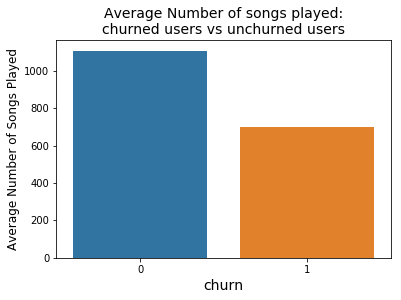

In [22]:
#plotting average number of songs for churn and non-churn users
df_plt = avg_num_songs_played.select(['churn', 'AvgNumberofSongs']).toPandas()
sns.barplot(x="churn", y="AvgNumberofSongs", data = df_plt)
plt.xlabel("churn", fontsize=14);
plt.ylabel("Average Number of Songs Played", fontsize=12);
plt.title("Average Number of songs played:\nchurned users vs unchurned users", fontsize=14);

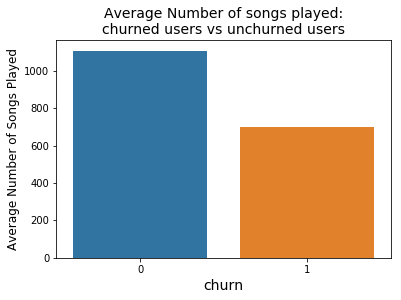

In [23]:
sns.barplot(x="churn", y="AvgNumberofSongs", data = df_plt)
plt.xlabel("churn", fontsize=14);
plt.ylabel("Average Number of Songs Played", fontsize=12);
plt.title("Average Number of songs played:\nchurned users vs unchurned users", fontsize=14);

In [24]:
# Average number of times each page is vistied: churned vs unchurned users.
df_page_churn_count = df.groupby(['churn','page']).agg({'page':'count'})

avg_num_page_visit = df_page_churn_count\
                .join(df_songs_unique_users, df_songs_unique_users.churn == df_page_churn_count.churn)\
                .drop(df_songs_unique_users.churn)

avg_num_page_visit = avg_num_page_visit\
                .withColumn('AvgNumberofPageVisit', \
                            avg_num_page_visit['count(page)']/avg_num_page_visit['count(DISTINCT userId)'])

In [25]:
# I am leaving out "NextSong" page as it dominates every other page, Moreover NextSong has been shown seperately in the plot above
avg_num_page_visit = avg_num_page_visit.filter(col('page') != 'NextSong')
avg_num_page_visit = avg_num_page_visit.toPandas()

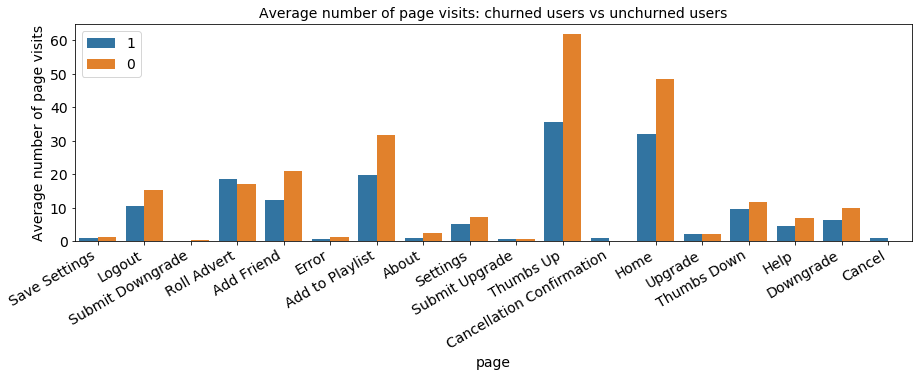

In [26]:
# Plotting average number of times each page is vistied: churned vs unchurned users.
fig = plt.figure(figsize=(15, 4))
sns.barplot(x="page",y="AvgNumberofPageVisit", hue="churn", data=avg_num_page_visit, hue_order=[1, 0]);
plt.xticks(rotation=90, fontsize=14);
plt.yticks(fontsize=14)
plt.xlabel("page", fontsize=14)
plt.ylabel("Average number of page visits", fontsize=14)
plt.title("Average number of page visits: churned users vs unchurned users", fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.legend(loc='best', fontsize=14);

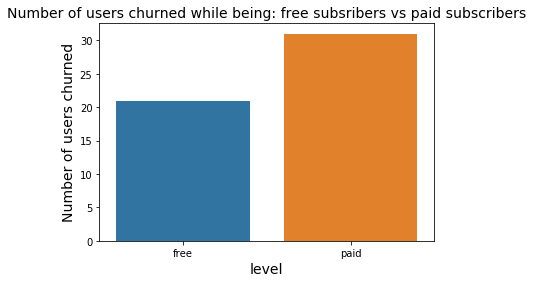

In [27]:
# number of users churned while being free subsribers vs paid subscribers
df_pd = df.filter(col('churn')==1).filter(df['page']=="Cancellation Confirmation").groupby("level").count().toPandas()
sns.barplot(x="level", y="count", data=df_pd);
plt.xlabel("level", fontsize=14);
plt.ylabel("Number of users churned", fontsize=14);
plt.title("Number of users churned while being: free subsribers vs paid subscribers", fontsize=14);

In [28]:
df_pd

,level,count
0,free,21
1,paid,31


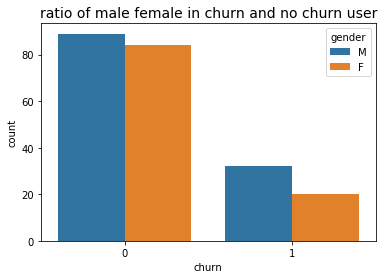

In [29]:
# Checking ratio of male and female in churn and no churn user
df_gen = df.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()
sns.barplot(x='churn', y='count', hue='gender', data=df_gen)
plt.title("ratio of male female in churn and no churn user", fontsize=14);

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

After analyzing all the column above i have decided to use below features in my model: <br/>
 1:- Gender
 2:- UserAgent
 3:- Status
 4;- Page
 5:- Level
 6:- ItemInSession

Once the columns were identified, we now have to make sure that they are all in the numeric datatype so that they could be put into the model that we choose. 
The Gender, UserAgent, level and page columns had to be converted into numeric values using a combination of String Indexing and One Hot encoding.


In [41]:
#build pipeline
Gender_indexer = StringIndexer(inputCol="gender", outputCol='Gender_Index')
User_indexer = StringIndexer(inputCol="userAgent", outputCol='User_Index')
Page_indexer = StringIndexer(inputCol="page", outputCol='Page_Index')
Level_Indexer = StringIndexer(inputCol="level", outputCol='Level_Index')

Gender_encoder = OneHotEncoder(inputCol='Gender_Index', outputCol='Gender_Vec')
User_encoder = OneHotEncoder(inputCol='User_Index', outputCol='User_Vec')
Page_encoder = OneHotEncoder(inputCol='Page_Index', outputCol='Page_Vec')
Level_encoder = OneHotEncoder(inputCol='Level_Index', outputCol='Level_Vec')

#create VectorAssembler to push data to ML models
assembler = VectorAssembler(inputCols=["Gender_Vec", "User_Vec", "Page_Vec","Level_Vec", "itemInSession","status"], outputCol="features")
indexer = StringIndexer(inputCol="churn", outputCol="label")

#Lets normalize data
scaler = Normalizer(inputCol="features", outputCol="ScaledFeatures");

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [42]:
#select classification functions
lr =  LogisticRegression(featuresCol="ScaledFeatures", labelCol = "label", maxIter=10, regParam=0.01, elasticNetParam=0)
rf = RandomForestClassifier(labelCol="label",featuresCol="ScaledFeatures", featureSubsetStrategy='sqrt')
gbt = GBTClassifier(featuresCol="ScaledFeatures", labelCol="label",featureSubsetStrategy='sqrt')

In [43]:
#Creating Pipelines
pipeline_lr = Pipeline(stages=[Gender_indexer, User_indexer, Page_indexer, Level_Indexer, Gender_encoder,\
                            User_encoder, Page_encoder, Level_encoder, assembler, indexer, scaler,lr])

pipeline_rf = Pipeline(stages=[Gender_indexer, User_indexer, Page_indexer, Level_Indexer, Gender_encoder,
                            User_encoder, Page_encoder, Level_encoder, assembler, indexer, scaler, rf])

pipeline_gbt = Pipeline(stages=[Gender_indexer, User_indexer, Page_indexer, Level_Indexer, Gender_encoder,
                            User_encoder, Page_encoder, Level_encoder, assembler, indexer, scaler, gbt])

In [44]:
#Train Test Split: As a first step break your data set into 90% 
#of training data and set aside 10%. Set random seed to 42.
train, test = df.randomSplit([0.9, 0.1], seed=42)

In [45]:
#Logistics Regression
import time
start_time= time.time()
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.1,]) \
    .build()

cv_lr = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=paramGrid_lr,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

cvModel_lr = cv_lr.fit(train)
avgMetrics_lr = cvModel_lr.avgMetrics
print (avgMetrics_lr)

end_time= time.time()

print("Total execution time for logistic:{}".format(round(end_time-start_time),3))

[0.8564222110222885, 0.841183504050214]
Total execution time for logistic:207.26939916610718


In [47]:
# Random forests model
import time
start_time= time.time()
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.impurity,['entropy', 'gini']) \
    .addGrid(rf.maxDepth,[2, 4, 6]) \
    .addGrid(rf.numTrees,[10, 25, 50]) \
    .build()

cv_rf = CrossValidator(estimator=pipeline_rf,
                             estimatorParamMaps=paramGrid_rf,
                             evaluator=MulticlassClassificationEvaluator(),
                             numFolds=3)

cvModel_rf = cv_rf.fit(train)
cvModel_rf.transform(test)
avgMetrics_rf = cvModel_rf.avgMetrics


end_time= time.time()
print("Total execution time for random forest model is:{}".format(round(end_time-start_time),3))

[0.7650162860001135, 0.7650162860001135, 0.7650162860001135, 0.7650162860001135, 0.8037844346433907, 0.8083707944697587, 0.7859354770345323, 0.79290345579184, 0.8253236082527606, 0.8270170273988777, 0.8275918940228532, 0.8252552932208839, 0.8441023970131769, 0.8375399520444945, 0.8415129238704779, 0.8456345192935, 0.7650162860001135, 0.7650162860001135, 0.7650162860001135, 0.7650162860001135, 0.8037146883671564, 0.8002349929661225, 0.7888811194977343, 0.7850415178351071, 0.8251539968876034, 0.8252813254355169, 0.8212255875132229, 0.8229870586298668, 0.8307459653523136, 0.8397403619127028, 0.8383282854926135, 0.847506167924034]
Total execution time for random forest model is:2752


In [48]:
# GBT model
import time
start_time= time.time()

paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxDepth,[4,6]) \
    .addGrid(gbt.stepSize,[0.01, 0.1]) \
    .build()

cv_gbt = CrossValidator(estimator=pipeline_gbt,
                             estimatorParamMaps=paramGrid_gbt,
                             evaluator=MulticlassClassificationEvaluator(),
                             numFolds=3)

cvModel_gbt = cv_gbt.fit(train)
cvModel_gbt.transform(test)
avgMetrics_gbt = cvModel_gbt.avgMetrics
print (avgMetrics_gbt)
end_time= time.time()
print("Total execution time for random forest model is:{}".format(round(end_time-start_time),3))

[0.8091992382545632, 0.8549961925603009, 0.8353822523267831, 0.8840332989738942, 0.853707717138471, 0.9086048267971762, 0.8600538080070187, 0.9104097229576691]


In [52]:
#Function will calcualte f1 scores:
def model_performance(model, test_data, metric = 'f1'):
    """ Calculate Model Scores using f1 metric 
        Input: 
            model- trained model or pipeline object
            metric- the metric used to measure performance
            data - data on which performance measurement should be done
        Output:
            score
    """
    evaluator = MulticlassClassificationEvaluator(metricName = metric)
    prediction_result = model.transform(test_data)
    # find f1 score
    score = evaluator.evaluate(prediction_result)
    #return score
    return score

F1_lr = model_performance(cvModel_lr, test)
F1_rf = model_performance(cvModel_rf, test)
F1_gbt = model_performance(cvModel_gbt, test)

In [63]:
#print both Model Testing F1-Score
print("Logistic Regression Model F1:{}".format(round(F1_lr,4)));
print("Random Forest  Classifier F1:{}".format(round(F1_rf,4)));
print("GBTClassifier  Classifier F1:{}".format(round(F1_gbt,4)));

Logistic Regression Model F1:0.8596
Random Forest  Classifier F1:0.8455
GBTClassifier  Classifier F1:0.9076


In [59]:
#Function will calcualte model accuracy:
def model_performance(model, test_data, metric = 'accuracy'):
    """ Calculate Model Scores using Accuracy Score 
        Input: 
            model- trained model or pipeline object
            metric- the metric used to measure performance
            data - data on which performance measurement should be done
        Output:
            score
    """
    evaluator = MulticlassClassificationEvaluator(metricName = metric)
    prediction_result = model.transform(test_data)
    # find f1 score
    score = evaluator.evaluate(prediction_result)
    #return score
    return score

Accuracy_lr = model_performance(cvModel_lr, test)
Accuracy_rf = model_performance(cvModel_rf, test)
Accuracy_gbt = model_performance(cvModel_gbt, test)

In [60]:
#print Model Testing Accuracy Score
print("Logistic Regression Model Accuracy:{}".format(round(Accuracy_lr,4)));
print("Random Forest Classifier Accuracy:{}".format(round(Accuracy_rf,4)));
print("GBTClassifier Classifier Accuracy:{}".format(round(Accuracy_gbt,4)));

Logistic Regression Classifier Accuracy:0.8787
Random Forest  Classifier Accuracy:0.8781
GBTClassifier  Classifier Accuracy:0.9167


With a F1 score of 0.9076 and accuracy of 0.9167, GBTClassifier is a preferred model to perform best with the sample data set. 

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.